In [1]:
import numpy as np
import pandas as pd

import os
print(os.listdir('aerial-cactus-identification/'))

import matplotlib.pyplot as plt 
plt.style.use("ggplot")

import cv2

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

['sample_submission.csv', 'test', 'test.zip', 'train', 'train.csv', 'train.zip']


In [2]:
train_df = pd.read_csv('aerial-cactus-identification/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [3]:
print(f"Train size: {len(os.listdir('aerial-cactus-identification/train'))}")
print(f"Test size: {len(os.listdir('aerial-cactus-identification/test'))}")

Train size: 17500
Test size: 4000


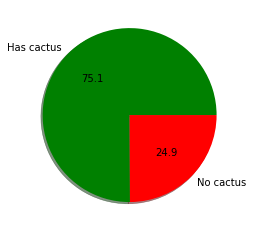

<Figure size 360x360 with 0 Axes>

In [4]:
value_counts = train_df['has_cactus'].value_counts()

%matplotlib inline
plt.pie(value_counts, labels=['Has cactus', 'No cactus'], colors=['Green', 'Red'], autopct='%1.1f', shadow=True)
plt.figure(figsize=(5, 5))
plt.show()

In [5]:
train_path = 'aerial-cactus-identification/train'
test_path = 'aerial-cactus-identification/test'

In [6]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [7]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [8]:
batch_size = 64
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [9]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

sample_sub = pd.read_csv('aerial-cactus-identification/sample_submission.csv')
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
classes = ['No Cactus', 'Cactus']

In [11]:
def imshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    

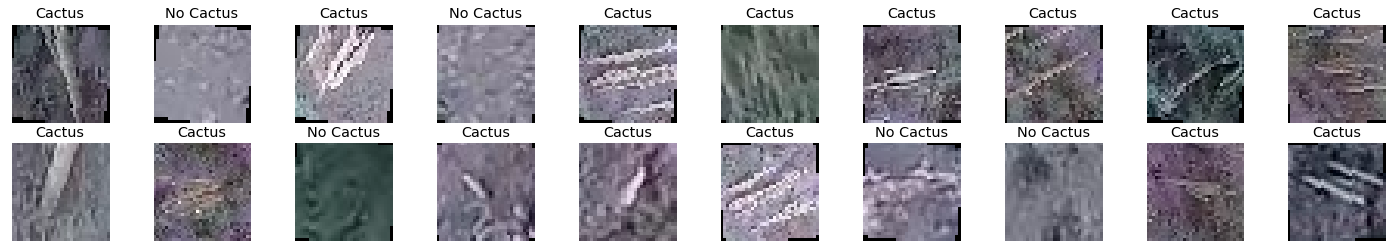

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

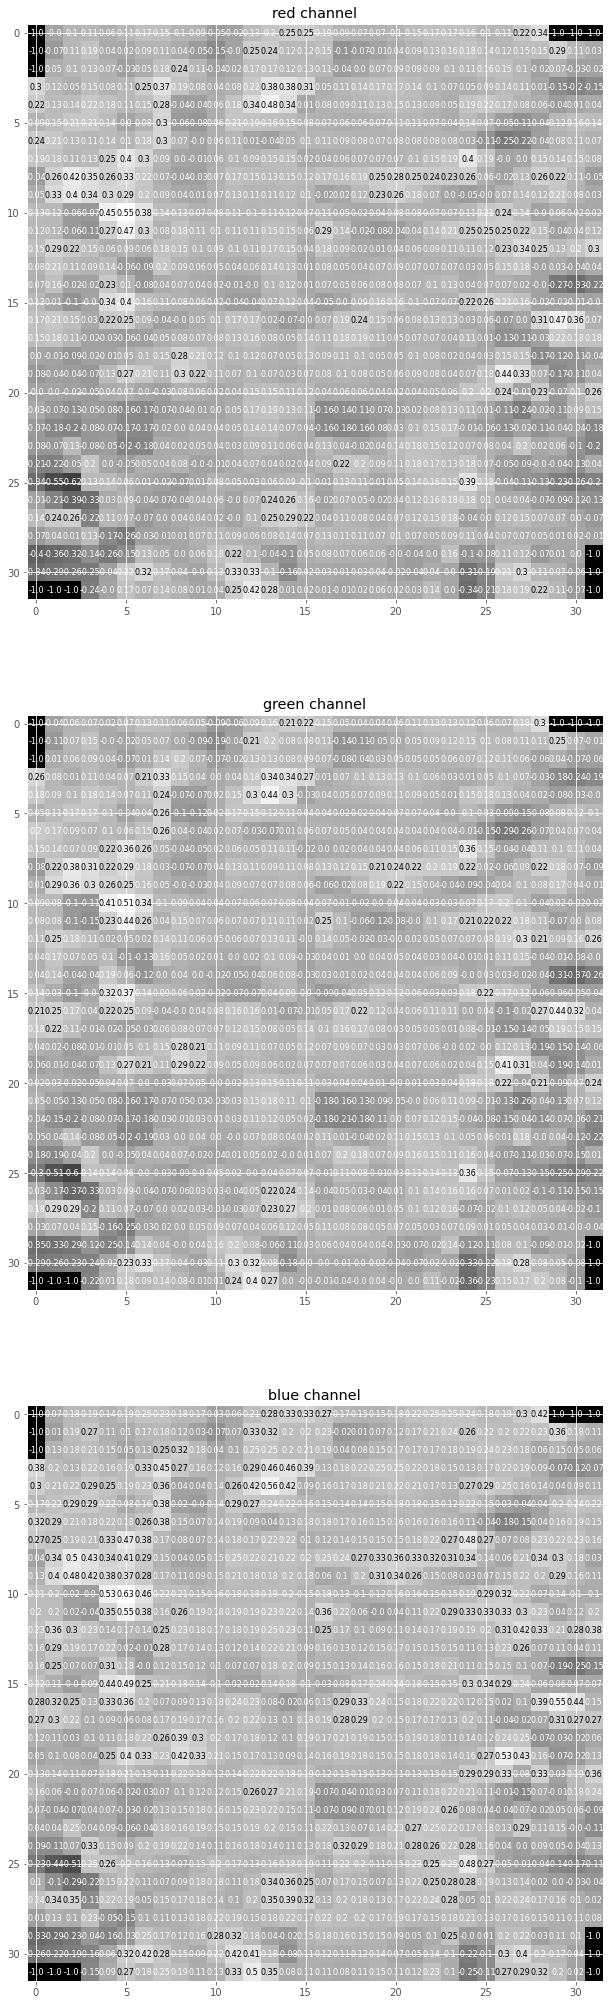

In [13]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize=(36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(3, 1, idx+1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y, x),
                       horizontalalignment='center',
                       verticalalignment='center', size=8, 
                       color='white' if img[x][y]<thresh else 'black')

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
#          Convolutional Layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
#         Convolutional Layer (see 16x16x16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         Convolutional Layer (see 8x8x32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
#         Convolutional Layer (see 4x4x64 image tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
#     Maxpooling Layer
        self.pool = nn.MaxPool2d(2, 2)
#         Linear Fully-Connected Layer 1 (see 2x2x128 image tensor)
        self.fc1 = nn.Linear(128*2*2, 512)
#         Linear FC Layer 2
        self.fc2 = nn.Linear(512, 2)
#         Set Dropout
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
#         add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
#         flatten image input
        x = x.view(-1, 128*2*2)
#     add dropout layer
        x= self.dropout(x)
#         add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
#         add dropout layer 
        x = self.dropout(x)
#         add 2nd hidden layer with relu activation function
        x = self.fc2(x)
        return x

In [16]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [17]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu: model.cuda()

In [20]:
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adamax(model.parameters(), lr=0.001)

In [30]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf #track change in validation loss

train_losses = []
valid_losses = []

###################
# train the model #
###################


for epoch in range(1, n_epochs+1):
    
    train_loss = 0
    valid_loss = 0
    model.train()

    for data,target in train_loader:
    #     move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
    #     clear the gradients of all optimized variables
        optimizer.zero_grad()
    #     forward pass: compute predicted outputs by passing inputs to the models
        output = model(data)
    #     calculate the batch loss
        loss = criterion(output, target)
    #     backward pass: compute gradient of the loss with respect to model parameter
        loss.backward()
    #     perform a single optimization step (parameter update)
        optimizer.step()
    #     update training losss
        train_loss += loss.item()*data.size(0)


    ######################
    # validate the model #
    ######################

    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
#         forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
#         calculate the batch loss
        loss = criterion(output, target)
#         update average validation loss
        valid_loss += loss.item()*data.size(0)
    
    #calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    #print training/ validation statistics
    print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(epoch, train_loss, valid_loss))
    
    #save model if validation loss has decreaed
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.015051 	Validation Loss: 0.034294
Validation loss decreased (inf --> 0.034294).  Saving model ...
Epoch: 2 	Training Loss: 0.012222 	Validation Loss: 0.029299
Validation loss decreased (0.034294 --> 0.029299).  Saving model ...
Epoch: 3 	Training Loss: 0.012678 	Validation Loss: 0.028085
Validation loss decreased (0.029299 --> 0.028085).  Saving model ...


KeyboardInterrupt: 

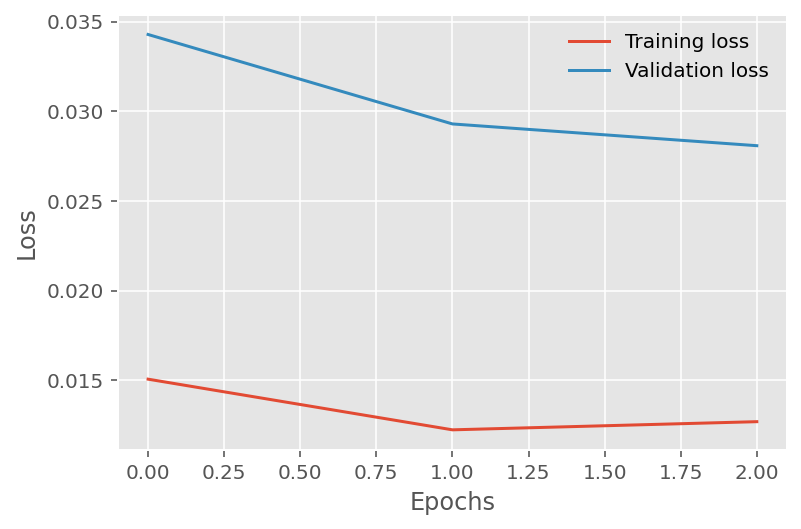

In [33]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label ='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [25]:
# load best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [28]:
model.eval()

preds = []
for batch_id, (data, target) in enumerate(test_loader):
#     data, target = data.cuda(), target.cuda()
    output = model(data)
    
    pr = output[:, 1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)
        
sample_sub['has_cactus'] = preds
sample_sub.to_csv('submission.csv', index=False)

In [29]:
%qtconsole